In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation
import utilis
%matplotlib qt


Set up two cameras, both with the internal parameters
<!-- # teta_x = 0.7
# teta_y = -0.5
# teta_z = 0.8
# first_matrix = np.array([[np.cos(teta_z), -np.sin(teta_z), 0], [np.sin(teta_z), np.cos(teta_z), 0], [0,0,1]])
# second_matrix = np.array([[np.cos(teta_y), 0, np.sin(teta_y)], [0, 1, 0], [-np.sin(teta_y),0,np.cos(teta_y)]])
# third_matrix = np.array([[1, 0, 0], [0, np.cos(teta_x), -np.sin(teta_x)], [0,np.sin(teta_x),np.cos(teta_x)]])
#  -->

In [2]:
K1 = K2 = np.array([[1000, 0, 300], [0, 1000, 200], [0, 0, 1]])

#Set up camera 1
R1= np.eye(3)
t1=np.array([[0], [0], [0]])

#Set up camera 2
t2= np.array([[0.2], [2], [1]])
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()

print(R2)


[[ 0.61141766 -0.76384514  0.20666167]
 [ 0.6295392   0.31131209 -0.71187442]
 [ 0.47942554  0.56535421  0.67121217]]


Consider the 3D point and find the projections in Cam1 and Cam2, respectively, points q1 and q2

In [3]:
#3D point Q
Q= np.array([[1], [0.5], [4]])

q1 = utilis.projectpoints(K1, R1, t1, Q)
q2 = utilis.projectpoints(K2, R2, t2, Q)

print(q1)
print(q2)



[[550.]
 [325.]]
[[582.47256835]
 [185.98985776]]


Implement a function CrossOp that takes a vector in 3D and returns the 3×3 matrix corresponding
to taking the cross product with that vector. In the case that p = èx y zéT you should have

In [4]:
def crossOp(x: np.ndarray):
    """
    Takes a vector in 3D and returns the 3x3 matrix corresponding
    to taking the cross product with that vector.

    Parameters:
    - x: 1D vector

    Output:
    - 3x3 matrix
    """
    x = x.flatten()
    M = np.array([[0, -x[2], x[1]], 
                [x[2], 0, -x[0]],
                [-x[1], x[0], 0]])
    return M

p = np.array([[3, 4, 5]]).T
print(crossOp(p))

[[ 0 -5  4]
 [ 5  0 -3]
 [-4  3  0]]


As always, verify that your function works. In this case, you can testing it on random vectors and
ensure that
[p1]×p2 = p1 × p2.

Exercise 3.3
Compute the fundamental matrix F of the two cameras

### 3.3 Fundamental matrices
F = inv(K2).T @ E @ inv(K1)

E = [t]_x * R 

In [5]:
def fundamental_matrix(R1, t1, R2, t2, K1, K2):
    """
    The R and t relates the two cameras.
    K1 and K2 for each camera.
    Returns the F which relates the camera on the pixel plane.
    """
    R = R2@R1.T 
    t = t2 - R2@R1.T@t1 
    E = crossOp(t)@R
    F = (np.linalg.inv(K2)).T @ E @ (np.linalg.inv(K1))
    return F

In [6]:
F = fundamental_matrix(R1, t1, R2, t2, K1, K2)
print(F)

[[ 3.29311881e-07  8.19396327e-07  1.79162592e-03]
 [ 5.15532551e-07 -8.76915984e-07  9.31426656e-05]
 [-1.29882755e-03  1.51951700e-03 -1.10072682e+00]]


The epipolar line is found by F*q1

### 3.4 Epipolar lines

F is what relates a point on one image plane to a line on the other. l2 = Fq1. 

Also, q2.T@F@q1 = 0, as q2 is on the epiploar line itself.

In [7]:
def epipolar_line(F: np.ndarray, q1: np.ndarray):
    """"
    Compute epipolar line

    Parameters:
    - F: Fundamental matrix (3,3)
    - q: 2D point in homogenous coordinates (3, N)
    """
    # 
    l = F@q1
    return l

In [8]:
#This is the product between F and the projected point q1
# Equation of the epipolar line in camera 2
l2 = epipolar_line(F, utilis.PiInv(q1))
utilis.Pi(l2)


array([[-1.69466035e-03],
       [-6.93953760e-05]])

Is q2 located on the epipolar line from Exercise 3.4? Do the computations, but also explain why
this must be so

### 3.5 On the line?

q2 must be on the line, as F is defined as q2.T @F@ q1 = 0.

To check if a point is on a line we can use q.T@l = 0, or q@l.T = 0...

q2 and l2 are both derived from the same 3D point Q, which yields a single epipolar plane, yielding a line in each camera. The points on one epiploar line must be found in the other, given perfect F matrix.

In [9]:
#Verifing that q2 is located on the epipolar line
is_q2_onTheLine = utilis.PiInv(q2).T@F@utilis.PiInv(q1)
is_q2_onTheLine = utilis.PiInv(q2).T @ l2
print(is_q2_onTheLine)


[[4.30211422e-16]]


#### TO SHOW HOW TO COMPUTE THE F MATRIX WITHOUT WORLD COORDINATE OF THE CAMERA 

Load the file TwoImageDataCar.npy, and compute the fundamental matrix between the images.
Tip: You can load the file with:
np.load('TwoImageDataCar.npy', allow_pickle=True).item()

In [10]:
two_image_data = np.load('images/TwoImageDataCar.npy', allow_pickle=True).item()
# Get the keys of the dictionary
keys = two_image_data.keys()

# Print the keys
print("Keys in two_image_data:", keys)

Keys in two_image_data: dict_keys(['im1', 'R1', 't1', 'im2', 'R2', 't2', 'K'])


In [11]:
gray_left = two_image_data["im1"]
gray_right = two_image_data["im2"]

R1 = two_image_data["R1"]
R2 = two_image_data["R2"]

t1 = two_image_data["t1"]
t2 = two_image_data["t2"]

K1 = two_image_data["K"]
K2 = K1.copy()


In [12]:
f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
ax_left.imshow(gray_left, cmap="gray")
ax_right.imshow(gray_right, cmap="gray")

In [13]:
#USE ALWAYS THIS R AND T GIVEN 2 CAMERAS

Rtilde = R2@R1.T # = R2...
ttilde = t2 - R2@R1.T@t1 # = t2...

F = fundamental_matrix(R1, t1, R2, t2, K1, K2)
F

array([[-1.50228281e-08, -3.45997421e-07, -3.47606501e-05],
       [-2.06767970e-07,  3.96284278e-08, -9.29558240e-04],
       [ 2.61581163e-05,  1.12168578e-03,  1.17449076e-02]])

Write code that can show both images at the same time. Now write code such that you can click
on a point in image one, and display the corresponding epipolar line in image two. Experiment
with your code, verifying that the point you click on is on the epipolar line in the other image.

In [14]:
def DrawLine(l, shape, ax):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    
    def in_frame(l_im):
        """Returns the intersection point of the line with the image frame."""
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    ax.plot(*np.array(P).T, c="r")

In [15]:
def click_epiline(img1, img2, F):
    # We need to turn off the matplotlib inline to use ginput.
    %matplotlib qt
    # Extract one inhomogenous point p in left image.
    plt.imshow(img1)
    x = plt.ginput(1) # one input
    plt.show()

    # Translate point to homogenous coordinates
    p1 = np.array(x).reshape(2, 1)
    q1 = utilis.PiInv(p1)

    # Use F-matrix to get the epipolar line of other camera.
    l2 = epipolar_line(F, q1)

    #Verifying the point is on the line
    is_q1_onTheLine = q1.T @ l2
    print(is_q1_onTheLine)

    # Return to inline plotting
    %matplotlib inline
    f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
    # left
    ax_left.imshow(img1, cmap="gray")
    ax_left.plot(p1[0], p1[1], 'ro')
    # right
    ax_right.imshow(img2, cmap="gray")
    DrawLine(l2, img2.shape, ax_right)
    # display
    plt.show()



[[-0.01190455]]


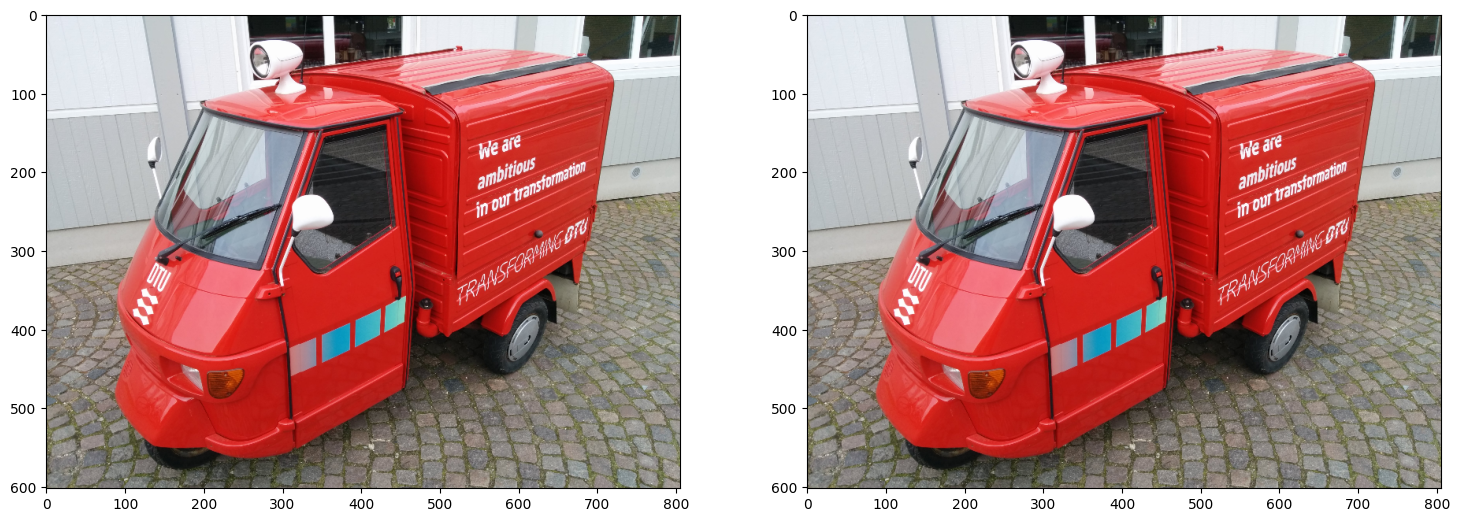

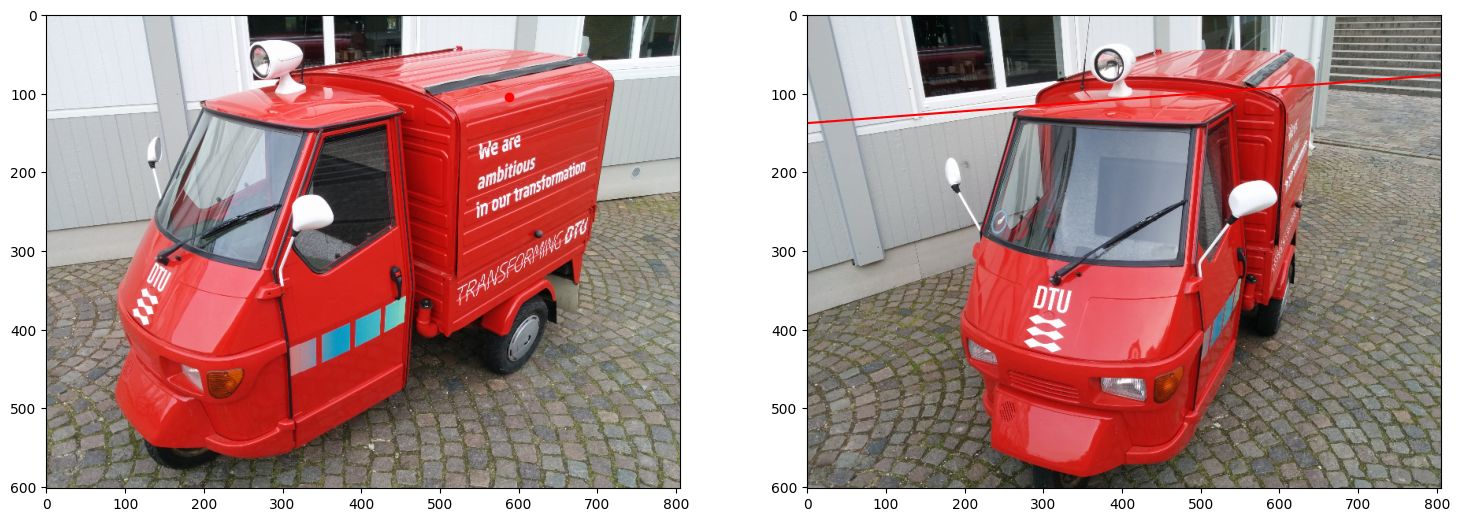

In [16]:
click_epiline(gray_left, gray_right, F)

### 3.10, opposite day!

- Go from img2 --> img1 instead
- Luckily, F gives a pretty easy transition between the two! 

$l_2 = F q_1$ and $l_1 = F^T q_2$

[[-0.05125812]]


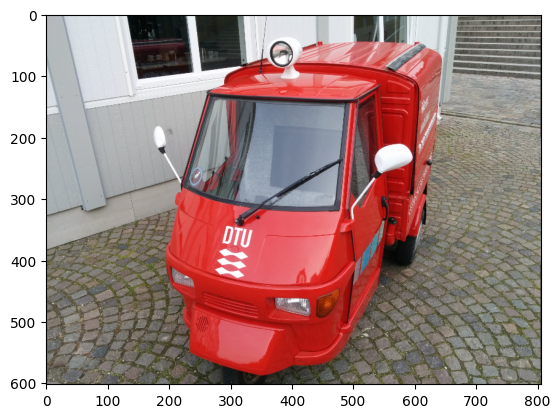

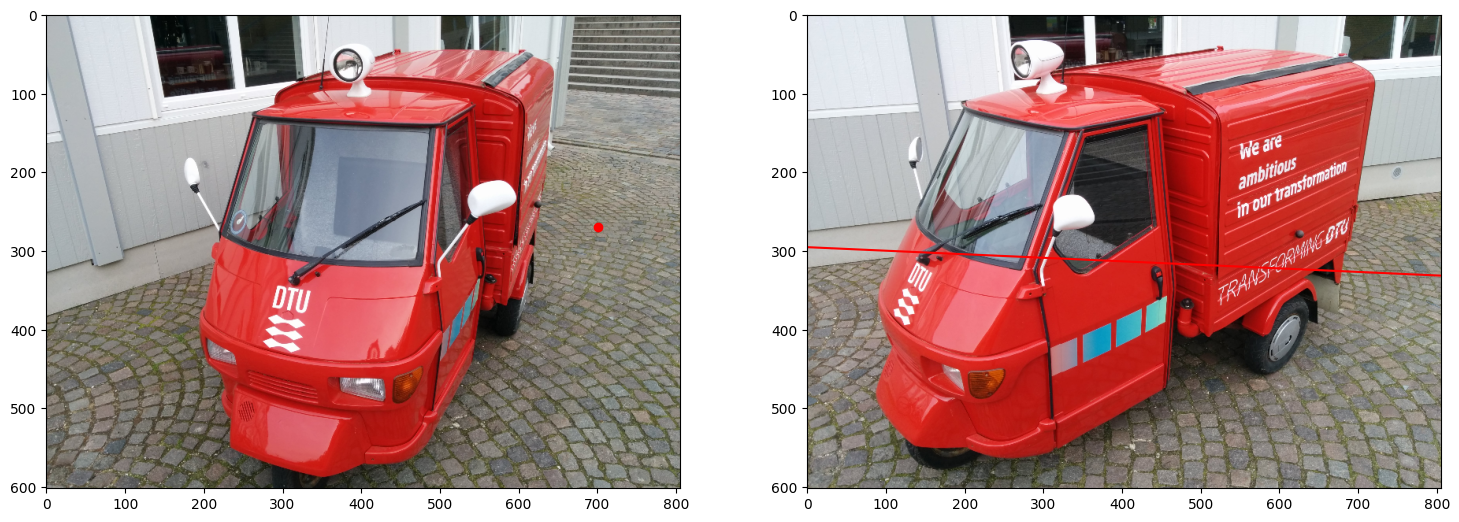

In [17]:
click_epiline(gray_right, gray_left, F.T)

### 3.11 Triangulation

- Using the pixel coordinates q1, q2, ..., qn we want to find the position of the points in 3D.
- use the linear algorithm presented at the end of lecture

Create a function triangulate. It should be able to triangulate a single 3D point that has been
seen by n different cameras. The function should take as input: a list of n pixel coordinates (q1, q2,
. . . , qn), and a list of n projection matrices (P1, P2, . . . , Pn), and should return the triangulation
of the point in 3D using the linear algorithm.

In [18]:
def triangulate(q, P):
    """
    Return the traingulation.
    
    Parameters
    ----------
    q: 2 x n numpy array
        Inhomogenous pixel coordinates q1... qn
        One for each camera seeing the point.
        At least two.
    P: list of 3 x 4 numpy arrays
        Projection matrices P1... Pn
        For each pixel coordinate
    
    Return
    ------
    Q: 3 x 1 numpy array
        Triangulation of the point using the linear SVD algorithm
    """
    _, n = q.shape # n = no. cameras has seen pixel.

    # Prepare B matrix. Two rows for each camera n.
    B = np.zeros((2 * n, 4))
    for i in range(n):
        B[2 * i: 2 * i + 2] = [
            P[i][2, :] * q[0, i] - P[i][0, :],
            P[i][2, :] * q[1, i] - P[i][1, :],
        ]
    # BQ = 0. Minimize using Svd.
    _, _, vh = np.linalg.svd(B)
    Q = vh[-1, :] # Q is ev. corresponding to the min. singular point.
    return Q[:3].reshape(3, 1) / Q[3] # Reshape and scale.

In [20]:
Q = np.array([[4], [6], [2]])
K1 = K2 = np.array([[1000, 0, 300], [0, 1000, 200], [0, 0, 1]])

#Set up camera 1
R1= np.eye(3)
t1=np.array([[0], [0], [0]])

#Set up camera 2
t2= np.array([[0.2], [2], [1]])
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()

# # Make the projection matrixes for both cameras.
# def getProjection_Matrix(K, R, t):
#     Rt = np.concatenate((R, t), axis=1)
#     return K @ Rt

P1 = utilis.getProjection_Matrix(K1, R1,t1)
P2 = utilis.getProjection_Matrix(K2, R2,t2)

# # Aquire the pixel points in each camera, using function from ex1.
q1 = utilis.projectpoints(K1, R1, t1, Q)
q2 = utilis.projectpoints(K2, R2, t2, Q)
print(q1.shape)
# print(q1.shape)

print("Actual Q:\n", Q, "\n-----------")
print("Q projected:\n", triangulate(np.hstack((q1, q2)), [P1, P2]))

(2, 1)
Actual Q:
 [[4]
 [6]
 [2]] 
-----------
Q projected:
 [[4.]
 [6.]
 [2.]]
